In [1]:
!pip install nilearn
!pip install tensorflow

import scipy.io
import numpy as np
import os
import scipy.io as sio
import scipy.stats as stats
from nilearn.connectome import sym_matrix_to_vec, vec_to_sym_matrix
from nilearn import plotting
from nilearn.datasets import fetch_atlas_harvard_oxford
import matplotlib.pyplot as plt
import seaborn as sns
from nilearn.datasets import fetch_atlas_schaefer_2018

from scipy.stats import ttest_ind

from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from nilearn.image import load_img
from nilearn.plotting import plot_markers
from nilearn.datasets import fetch_atlas_harvard_oxford
from nilearn.image import coord_transform
import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix

from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error


from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix



from nilearn.image import new_img_like
import nibabel as nib

import pandas as pd


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 55.9 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
file_paths = [
    '/content/drive/MyDrive/Colab Notebooks/adj_matrices/13D5adj_mat.mat',

    '/content/drive/MyDrive/Colab Notebooks/adj_matrices/13EFadj_mat.mat',

    '/content/drive/MyDrive/Colab Notebooks/adj_matrices/13ERadj_mat.mat',

    '/content/drive/MyDrive/Colab Notebooks/adj_matrices/13FMadj_mat.mat',

    '/content/drive/MyDrive/Colab Notebooks/adj_matrices/13K8adj_mat.mat',

    '/content/drive/MyDrive/Colab Notebooks/adj_matrices/13J1adj_mat.mat',

    '/content/drive/MyDrive/Colab Notebooks/adj_matrices/13E7adj_mat.mat',

    '/content/drive/MyDrive/Colab Notebooks/adj_matrices/13JBadj_mat.mat',

    '/content/drive/MyDrive/Colab Notebooks/adj_matrices/13CCadj_mat.mat',

    '/content/drive/MyDrive/Colab Notebooks/adj_matrices/13M5adj_mat.mat',

    '/content/drive/MyDrive/Colab Notebooks/adj_matrices/146Qadj_mat.mat',

    '/content/drive/MyDrive/Colab Notebooks/adj_matrices/13MNadj_mat.mat',

    '/content/drive/MyDrive/Colab Notebooks/adj_matrices/148Gadj_mat.mat',

    '/content/drive/MyDrive/Colab Notebooks/adj_matrices/1470adj_mat.mat',

    '/content/drive/MyDrive/Colab Notebooks/adj_matrices/1484adj_mat.mat'
]

adjacency_matrices = []

for file_path in file_paths:
    mat_data = scipy.io.loadmat(file_path)
    key = next(key for key in mat_data.keys() if not key.startswith("__"))
    adjacency_matrices.append(mat_data[key])

matrix_shapes = [matrix.shape for matrix in adjacency_matrices]
matrix_shapes


[(148, 148, 107),
 (148, 148, 36),
 (148, 148, 72),
 (148, 148, 54),
 (148, 148, 68),
 (148, 148, 69),
 (148, 148, 85),
 (148, 148, 71),
 (148, 148, 36),
 (148, 148, 87),
 (148, 148, 70),
 (148, 148, 76),
 (148, 148, 66),
 (148, 148, 80),
 (148, 148, 46)]

In [4]:
combined_connectivity_matrix = np.concatenate(adjacency_matrices, axis=-1)

print("Shape of connectivity matrix:", combined_connectivity_matrix.shape)
output_file_path = 'combined_connectivity_matrix.mat'
sio.savemat(output_file_path, {'combined_connectivity_matrix': combined_connectivity_matrix})

Shape of connectivity matrix: (148, 148, 1023)


In [5]:
ages = np.array([24, 24, 23, 19, 19, 28, 30, 31, 36, 46, 47, 55, 55, 59, 66])
slice_counts = [matrix.shape[2] for matrix in adjacency_matrices]
labels = np.repeat(ages, slice_counts)
label_matrix = labels[:, np.newaxis]
label_output_file_path = 'label_matrix.mat'

sio.savemat(label_output_file_path, {'label_matrix': label_matrix})

print("Shape of label matrix:", label_matrix.shape)

Shape of label matrix: (1023, 1)


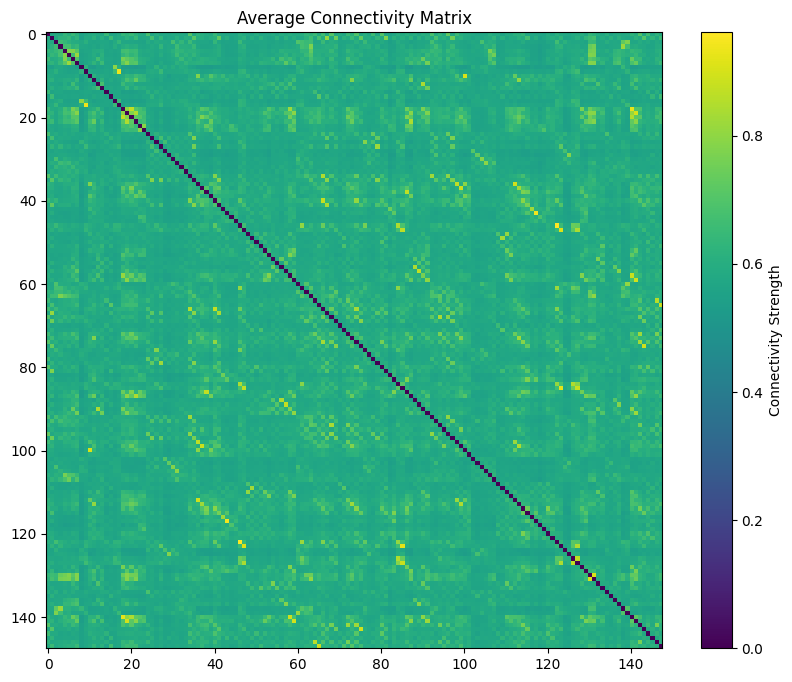

In [6]:
#compute the average connectivity matrix
average_connectivity_matrix = np.mean(combined_connectivity_matrix, axis=-1)

plt.figure(figsize=(10, 8))
plt.imshow(average_connectivity_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Connectivity Strength')
plt.title('Average Connectivity Matrix')
plt.show()

The mean of the significant p-values is: 0.0030


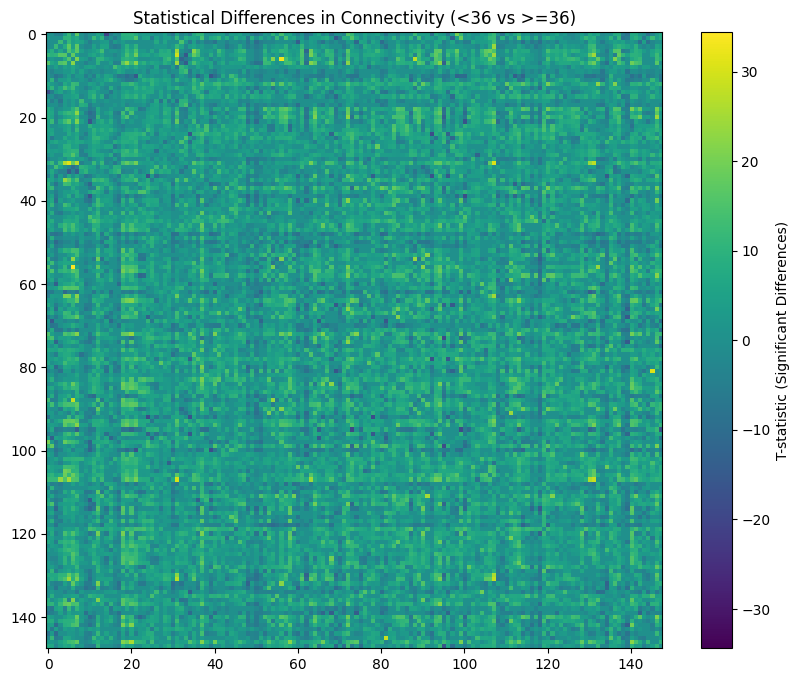

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# Define two groups: young and old
young_indices = np.where(labels < 36)[0]
old_indices = np.where(labels >= 36)[0]

young_connectivity = combined_connectivity_matrix[:, :, young_indices]
old_connectivity = combined_connectivity_matrix[:, :, old_indices]
mean_young = np.mean(young_connectivity, axis=-1)
mean_old = np.mean(old_connectivity, axis=-1)


t_stat, p_values = ttest_ind(young_connectivity, old_connectivity, axis=-1, equal_var=False)


significance_mask = p_values < 0.05  # Threshold for significance

mean_p_value = np.mean(p_values[significance_mask]) if np.any(significance_mask) else np.nan
print(f"The mean of the significant p-values is: {mean_p_value:.4f}")
t_stat_significant = np.where(significance_mask, t_stat, 0)


plt.figure(figsize=(10, 8))
plt.imshow(t_stat_significant, cmap='viridis', interpolation='nearest',
           vmin=-np.max(np.abs(t_stat_significant)), vmax=np.max(np.abs(t_stat_significant)))
plt.colorbar(label='T-statistic (Significant Differences)')
plt.title('Statistical Differences in Connectivity (<36 vs >=36)')
plt.show()


In [8]:
def flatten_matrices(combined_matrix, discard_diagonal=True):
    """Flatten symmetric matrices using the upper triangle and remove the diagonal"""
    def sym_matrix_to_vec_manual(matrix, discard_diagonal=True):
        triu_indices = np.triu_indices_from(matrix, k=1 if discard_diagonal else 0)
        return matrix[triu_indices]

    return np.array([sym_matrix_to_vec_manual(combined_matrix[:, :, i], discard_diagonal=discard_diagonal)
                     for i in range(combined_matrix.shape[2])])

flattened_matrices = flatten_matrices(combined_connectivity_matrix)
print("Shape of flattened matrices:", flattened_matrices.shape)


Shape of flattened matrices: (1023, 10878)


In [9]:
ages = np.array([24, 24, 23, 19, 19, 28, 30, 31, 36, 46, 47, 55, 55, 59, 66])

slice_counts = [matrix.shape[2] for matrix in adjacency_matrices]

labels = np.repeat(ages, slice_counts)

labels_binary = np.array([0 if age < 36 else 1 for age in labels])  # 0: Young, 1: Old


In [ ]:
# k = 10
# selector = SelectKBest(score_func=f_classif, k=k)
# X_selected = selector.fit_transform(flattened_matrices, labels_binary)

# selected_indices = selector.get_support(indices=True)
# print("Selected features indices:", selected_indices)

In [ ]:
# from sklearn.feature_selection import SelectKBest, f_classif
# from sklearn.model_selection import cross_val_score
# from sklearn.ensemble import RandomForestClassifier
# import numpy as np

# # Define range for k
# k_values = range(1, flattened_matrices.shape[1] + 1, 5)  # Test k in steps of 5
# cv_scores = []

# for k in k_values:
#     # Select top k features
#     selector = SelectKBest(score_func=f_classif, k=k)
#     features_selected = selector.fit_transform(flattened_matrices, labels_binary)

#     # Evaluate with Random Forest
#     rf_classifier = RandomForestClassifier(random_state=42, n_estimators=30)
#     scores = cross_val_score(rf_classifier, features_selected, labels_binary, cv=5, scoring='accuracy')
#     cv_scores.append(np.mean(scores))

# # Find the optimal k
# optimal_k = k_values[np.argmax(cv_scores)]
# print(f"Optimal number of features (k): {optimal_k}")

# # Plot the results
# import matplotlib.pyplot as plt
# plt.figure(figsize=(10, 6))
# plt.plot(k_values, cv_scores, marker='o')
# plt.xlabel('Number of Features (k)')
# plt.ylabel('Mean CV Accuracy')
# plt.title('Feature Selection with SelectKBest')
# plt.grid()
# plt.show()


In [ ]:
# from sklearn.feature_selection import SelectKBest, f_classif
# from sklearn.decomposition import PCA
# import numpy as np

# # Step 1: Perform Feature Selection
# k = 200 # Number of top features to select
# selector = SelectKBest(score_func=f_classif, k=k)
# selected_features = selector.fit_transform(flattened_matrices, labels_binary)

# print(f"Selected Features Shape: {selected_features.shape}")

# # Step 2: Apply PCA to the Selected Features
# pca = PCA(n_components=0.95)  # Retain 95% of the variance
# features_pca = pca.fit_transform(selected_features)

# print(f"Reduced Features Shape After PCA: {features_pca.shape}")


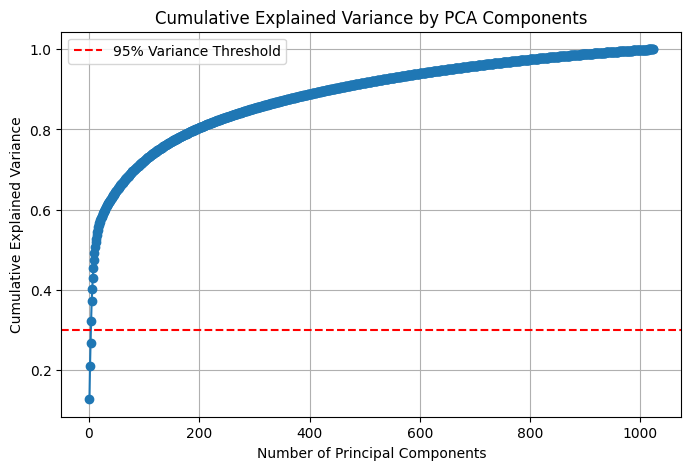

In [14]:
def perform_exploratory_pca(flattened_matrices):
    """Perform PCA for explained variance analysis."""
    pca_exploration = PCA()
    pca_exploration.fit(flattened_matrices)
    cumulative_variance = np.cumsum(pca_exploration.explained_variance_ratio_)

    #plot explained variance
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
    plt.axhline(y=0.30, color='r', linestyle='--', label='95% Variance Threshold')
    plt.title('Cumulative Explained Variance by PCA Components')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.legend()
    plt.grid()
    plt.show()

    return cumulative_variance

cumulative_variance = perform_exploratory_pca(flattened_matrices)

In [15]:
def perform_feature_extraction_pca(flattened_matrices, n_components):
    """Perform PCA to generate features for machine learning."""
    pca = PCA(n_components=n_components)
    features_pca = pca.fit_transform(flattened_matrices)
    return pca, features_pca

optimal_components = np.argmax(cumulative_variance >= 0.3) + 1
print(f"Optimal number of components to retain 30% variance: {optimal_components}")

pca, features_pca = perform_feature_extraction_pca(flattened_matrices, n_components=optimal_components)
print("Shape of PCA features:", features_pca.shape)

Optimal number of components to retain 30% variance: 4
Shape of PCA features: (1023, 4)


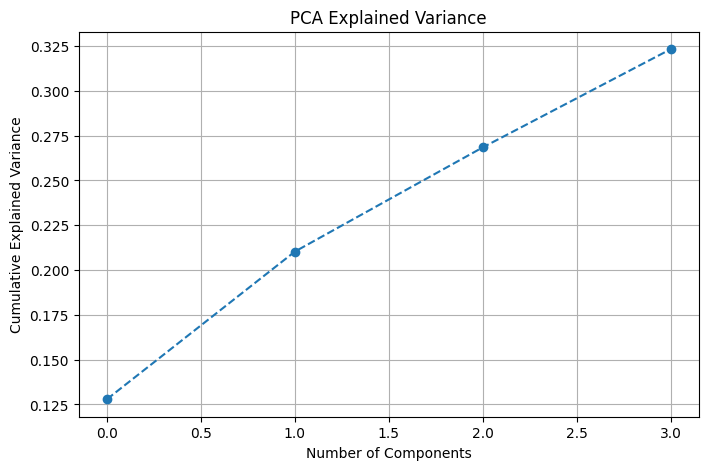

In [13]:

plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid()
plt.show()



In [ ]:
# from sklearn.feature_selection import SelectKBest, mutual_info_classif

# # Select the top k features based on mutual information
# k = 12  # Number of top features to select
# selector = SelectKBest(score_func=mutual_info_classif, k=k)
# features_pca_reduced = selector.fit_transform(features_pca, labels_binary)

# # Get the indices of selected features
# selected_indices = selector.get_support(indices=True)
# print(f"Selected Feature Indices: {selected_indices}")
# print(f"Reduced features shape: {features_pca_reduced.shape}")


In [17]:


# Load the Schaefer atlas with 200 parcels
atlas = fetch_atlas_schaefer_2018(n_rois=200)
atlas_filename = atlas['maps']
atlas_img = nib.load(atlas_filename)
labels = atlas['labels']

num_regions = len(labels)  # Number of atlas regions
num_components = 4


def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

features_pca_normalized = np.apply_along_axis(normalize, 0, features_pca)

# Threshold to keep only significant features
threshold = 0.4
features_pca_significant = np.where(np.abs(features_pca) >= threshold, features_pca, 0)

for i in range(num_components):
    component_region_values = np.zeros_like(atlas_img.get_fdata(), dtype=np.float32)
    valid_region_indices = np.arange(1, num_regions + 1)

    atlas_data = atlas_img.get_fdata()
    valid_voxel_mask = np.isin(atlas_data, valid_region_indices)

    component_data = features_pca_normalized[:, i]

    for idx, value in enumerate(component_data):
        if idx + 1 in valid_region_indices and np.abs(features_pca[idx, i]) >= threshold:
            component_region_values[(atlas_data == idx + 1) & valid_voxel_mask] += value


    component_pca_img = new_img_like(atlas_img, component_region_values)

    fig, ax = plt.subplots(figsize=(10, 8))
    display = plotting.plot_stat_map(
        component_pca_img,
        title=f"PCA Component {i + 1} (Significant Features Only)",
        display_mode="z",
        cut_coords=8,
        cmap="coolwarm",
        colorbar=True,
        axes=ax
    )

    print(f"PCA Component {i + 1} - Top Regions with Significant Contributions:")
    significant_regions = []
    for idx, label in enumerate(labels):
        if idx + 1 in valid_region_indices and np.any(component_region_values[atlas_data == idx + 1]):
            mean_value = component_region_values[atlas_data == idx + 1].mean()
            significant_regions.append((label, mean_value))


    significant_regions = sorted(significant_regions, key=lambda x: abs(x[1]), reverse=True)[:10]
    for label, value in significant_regions:
        print(f"  {label}: {value:.4f}")

plt.show()


ValueError: Requested n_rois=148 not available. Valid options: [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from nilearn import plotting
from nilearn.datasets import fetch_atlas_schaefer_2018
from nilearn.image import new_img_like
import nibabel as nib

# Load the Schaefer atlas with 200 parcels
atlas = fetch_atlas_schaefer_2018(n_rois=200)
atlas_filename = atlas['maps']
atlas_img = nib.load(atlas_filename)  # Load the atlas file as a NIfTI image
labels = atlas['labels']

num_regions = len(labels)  # Number of atlas regions
num_components = 4


def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

features_pca_normalized = np.apply_along_axis(normalize, 0, features_pca)

# Threshold to keep only significant features
threshold = 0.4
features_pca_significant = np.where(np.abs(features_pca) >= threshold, features_pca, 0)

for i in range(num_components):
    component_region_values = np.zeros_like(atlas_img.get_fdata(), dtype=np.float32)
    valid_region_indices = np.arange(1, num_regions + 1)

    atlas_data = atlas_img.get_fdata()
    valid_voxel_mask = np.isin(atlas_data, valid_region_indices)

    component_data = features_pca_normalized[:, i]

    for idx, value in enumerate(component_data):
        if idx + 1 in valid_region_indices and np.abs(features_pca[idx, i]) >= threshold:
            component_region_values[(atlas_data == idx + 1) & valid_voxel_mask] += value

    component_pca_img = new_img_like(atlas_img, component_region_values)

    fig, ax = plt.subplots(figsize=(10, 8))
    display = plotting.plot_stat_map(
        component_pca_img,
        display_mode="z",
        cut_coords=8,
        cmap="coolwarm",
        colorbar=True,
        axes=ax
    )

    # Modify colorbar to be horizontal and remove title
    cbar = display._cbar
    cbar.set_orientation('horizontal')
    cbar.ax.set_position([0.2, 0.1, 0.6, 0.02])  # Adjust position and size of the colorbar
    ax.set_title("")

    print(f"PCA Component {i + 1} - Top Regions with Significant Contributions:")
    significant_regions = []
    for idx, label in enumerate(labels):
        if idx + 1 in valid_region_indices and np.any(component_region_values[atlas_data == idx + 1]):
            mean_value = component_region_values[atlas_data == idx + 1].mean()
            significant_regions.append((label, mean_value))

    significant_regions = sorted(significant_regions, key=lambda x: abs(x[1]), reverse=True)[:10]
    for label, value in significant_regions:
        print(f"  {label}: {value:.4f}")

plt.show()


[get_dataset_dir] Dataset found in /root/nilearn_data/schaefer_2018

NameError: name 'features_pca' is not defined

In [ ]:
from scipy.ndimage import center_of_mass
import numpy as np
import matplotlib.pyplot as plt
from nilearn import plotting
from nilearn.datasets import fetch_atlas_schaefer_2018
from nilearn.image import new_img_like
import nibabel as nib

# Load the Schaefer atlas with 200 parcels
atlas = fetch_atlas_schaefer_2018(n_rois=200)
atlas_filename = atlas['maps']
atlas_img = nib.load(atlas_filename)
labels = atlas['labels']

num_regions = len(labels)  # Number of atlas regions
num_components = 4


def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

features_pca_normalized = np.apply_along_axis(normalize, 0, features_pca)

# Threshold to keep only significant features
threshold = 0.4
features_pca_significant = np.where(np.abs(features_pca) >= threshold, features_pca, 0)

for i in range(num_components):
    component_region_values = np.zeros_like(atlas_img.get_fdata(), dtype=np.float32)
    valid_region_indices = np.arange(1, num_regions + 1)

    atlas_data = atlas_img.get_fdata()
    valid_voxel_mask = np.isin(atlas_data, valid_region_indices)

    component_data = features_pca_normalized[:, i]

    for idx, value in enumerate(component_data):
        if idx + 1 in valid_region_indices and np.abs(features_pca[idx, i]) >= threshold:
            component_region_values[(atlas_data == idx + 1) & valid_voxel_mask] += value

    component_pca_img = new_img_like(atlas_img, component_region_values)

    fig, ax = plt.subplots(figsize=(10, 8))
    display = plotting.plot_stat_map(
        component_pca_img,
        title=f"PCA Component {i + 1} (Significant Features Only)",
        display_mode="z",
        cut_coords=8,
        cmap="coolwarm",
        colorbar=True,
        axes=ax
    )

    print(f"PCA Component {i + 1} - Top Regions with Significant Contributions:")
    significant_regions = []
    region_coords = []

    for idx, label in enumerate(labels):
        if idx + 1 in valid_region_indices and np.any(component_region_values[atlas_data == idx + 1]):
            mean_value = component_region_values[atlas_data == idx + 1].mean()
            region_center = center_of_mass(component_region_values, labels=(atlas_data == idx + 1))
            significant_regions.append((label, mean_value, region_center))
            region_coords.append(region_center)

    # Sort regions by contribution and keep only the top 10
    significant_regions = sorted(significant_regions, key=lambda x: abs(x[1]), reverse=True)[:10]
    for label, value, center in significant_regions:
        print(f"  {label}: {value:.4f}")

    # Annotate the brain map with region names
    for label, value, center in significant_regions:
        if center:  # Check if a valid center is found
            ax.text(center[0], center[1], label.decode('utf-8'), fontsize=8, color='black')

plt.show()


[get_dataset_dir] Dataset found in /root/nilearn_data/schaefer_2018

PCA Component 1 - Top Regions with Significant Contributions:
  b'7Networks_LH_SomMot_3': 0.7368
  b'7Networks_LH_Default_Par_1': 0.7071
  b'7Networks_LH_Vis_11': 0.6961
  b'7Networks_LH_Cont_Par_2': 0.6881
  b'7Networks_LH_SomMot_1': 0.6878
  b'7Networks_LH_Limbic_TempPole_1': 0.6874
  b'7Networks_LH_Cont_Temp_1': 0.6863
  b'7Networks_LH_SomMot_4': 0.6836
  b'7Networks_LH_DorsAttn_FEF_2': 0.6834
  b'7Networks_LH_Cont_Par_3': 0.6817
PCA Component 2 - Top Regions with Significant Contributions:
  b'7Networks_LH_SalVentAttn_FrOperIns_1': 1.0000
  b'7Networks_LH_Default_Temp_5': 0.9788
  b'7Networks_LH_DorsAttn_FEF_2': 0.9741
  b'7Networks_LH_Default_Par_1': 0.9718
  b'7Networks_LH_Limbic_TempPole_3': 0.9670
  b'7Networks_LH_Default_PFC_4': 0.9602
  b'7Networks_LH_DorsAttn_Post_4': 0.9430
  b'7Networks_LH_SomMot_4': 0.9416
  b'7Networks_LH_DorsAttn_Post_10': 0.9405
  b'7Networks_LH_DorsAttn_Post_5': 0.9372
PCA Component 3 - Top Regions with Significant Contributions:
  b'7Networks_RH_Cont

In [17]:
X_train, X_test, y_train, y_test = train_test_split(features_pca, labels_binary, test_size=0.3, random_state=42, stratify=labels_binary)


In [ ]:
rf_classifier = RandomForestClassifier(random_state=42, n_estimators=100)
rf_classifier.fit(X_train, y_train)

y_pred_rf = rf_classifier.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

print("Random Forest Accuracy:", accuracy_rf)
print("Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=["Young", "Old"]))
print("Random Forest Confusion Matrix:\n", conf_matrix_rf)

Random Forest Accuracy: 0.9511400651465798
Classification Report:
              precision    recall  f1-score   support

       Young       0.97      0.94      0.95       169
         Old       0.93      0.96      0.95       138

    accuracy                           0.95       307
   macro avg       0.95      0.95      0.95       307
weighted avg       0.95      0.95      0.95       307

Random Forest Confusion Matrix:
 [[159  10]
 [  5 133]]


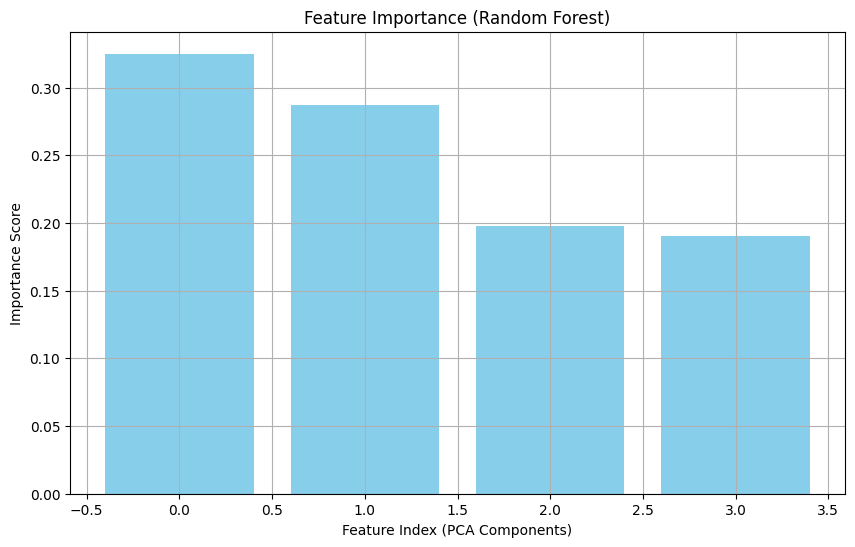

In [ ]:
feature_importances = rf_classifier.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), feature_importances[sorted_indices], color='skyblue')
plt.title('Feature Importance (Random Forest)')
plt.xlabel('Feature Index (PCA Components)')
plt.ylabel('Importance Score')
plt.grid()
plt.show()


In [ ]:
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(rf_classifier, X_train, y_train, cv=10, scoring='accuracy')
print(f"Mean CV Accuracy: {np.mean(cv_scores):.4f}")
print(f"CV Standard Deviation: {np.std(cv_scores):.4f}")

Mean CV Accuracy: 0.9328
CV Standard Deviation: 0.0233


In [ ]:
import pandas as pd

# Define the Random Forest results
rf_results_combined = {
    "Metric": ["Test Accuracy", "Macro Precision", "Macro Recall", "Macro F1-Score", "Mean CV Accuracy", "CV Standard Deviation"],
    "Value": [0.9171, 0.92, 0.92, 0.92, 0.9328, 0.0233]
}

# Create a DataFrame
rf_results_combined_df = pd.DataFrame(rf_results_combined)

# Save the results to an Excel file
rf_results_combined_df.to_excel("RandomForest_Results_Combined.xlsx", index=False, sheet_name="RF Results Combined")

print("Results saved to 'RandomForest_Results_Combined.xlsx'")


Results saved to 'RandomForest_Results_Combined.xlsx'


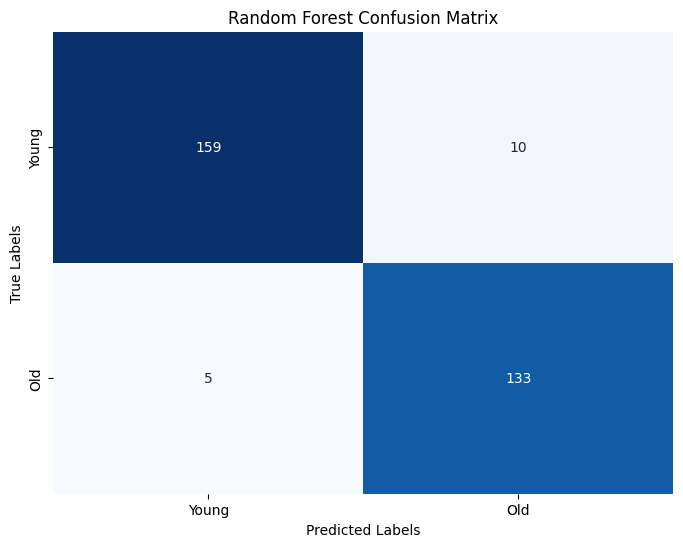

In [ ]:


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Young', 'Old'], yticklabels=['Young', 'Old'])


plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()




Fitting 5 folds for each of 18 candidates, totalling 90 fits
SVM Test Accuracy: 0.9381

SVM Classification Report:
              precision    recall  f1-score   support

       Young       1.00      0.89      0.94       169
         Old       0.88      1.00      0.94       138

    accuracy                           0.94       307
   macro avg       0.94      0.94      0.94       307
weighted avg       0.95      0.94      0.94       307

SVM Confusion Matrix:
[[150  19]
 [  0 138]]


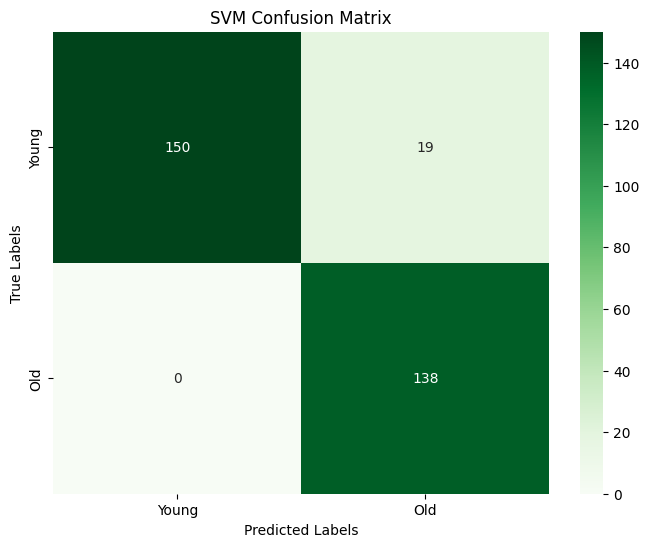

Mean CV Accuracy: 0.8325
CV Standard Deviation: 0.2050


In [ ]:

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC())
])

param_grid = {
    'svm__C': [0.1, 1, 10],
    'svm__kernel': ['linear', 'rbf'],
    'svm__gamma': ['scale', 0.1, 0.01]
}

svm_grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
svm_grid.fit(X_train, y_train)


best_svm = svm_grid.best_estimator_


y_pred_svm = best_svm.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)

print(f"SVM Test Accuracy: {accuracy_svm:.4f}")
print("\nSVM Classification Report:")
print(classification_report(y_test, y_pred_svm, target_names=["Young", "Old"]))

print("SVM Confusion Matrix:")
print(conf_matrix_svm)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap='Greens', xticklabels=['Young', 'Old'], yticklabels=['Young', 'Old'])
plt.title('SVM Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

cv_scores = cross_val_score(best_svm, features_pca, labels_binary, cv=10, scoring='accuracy')


print(f"Mean CV Accuracy: {np.mean(cv_scores):.4f}")
print(f"CV Standard Deviation: {np.std(cv_scores):.4f}")


In [ ]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

y_pred_lr = log_reg.predict(X_test)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f"Logistic Regression Accuracy: {accuracy_lr:.4f}")


Logistic Regression Accuracy: 0.8795


In [ ]:
# feature_importances = np.abs(best_svm.coef_).mean(axis=0)
# sorted_indices = np.argsort(feature_importances)[::-1]

# plt.figure(figsize=(10, 6))
# plt.bar(range(len(feature_importances)), feature_importances[sorted_indices], color='skyblue')
# plt.title('Feature Importance (PCA Components)')
# plt.xlabel('Feature Index')
# plt.ylabel('Importance Score')
# plt.grid()
# plt.show()


In [ ]:
# from sklearn.metrics import roc_curve, roc_auc_score
# import matplotlib.pyplot as plt

# # Compute decision function or probabilities
# y_proba_svm = best_svm.decision_function(X_test)
# fpr, tpr, _ = roc_curve(y_test, y_proba_svm)
# roc_auc = roc_auc_score(y_test, y_proba_svm)

# # Plot ROC Curve
# plt.figure(figsize=(8, 6))
# plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='blue')
# plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess')
# plt.title('SVM ROC Curve')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.legend()
# plt.grid()
# plt.show()


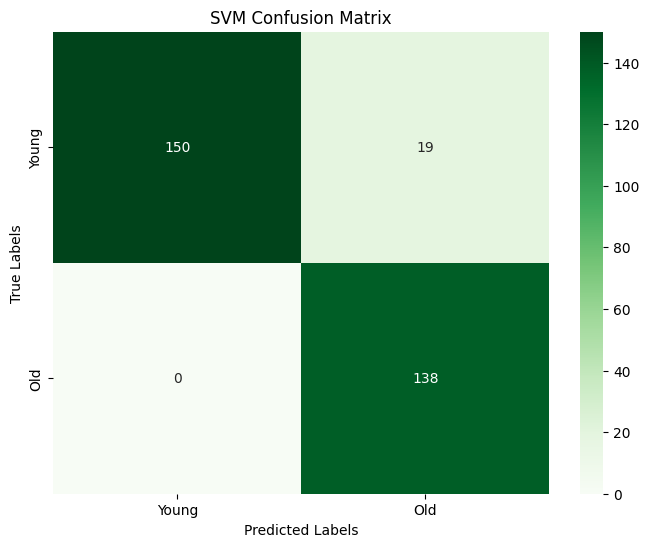

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, fmt='d', cmap='Greens', xticklabels=['Young', 'Old'], yticklabels=['Young', 'Old'])
plt.title('SVM Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

nn_model = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.4),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(1, activation='sigmoid')
])

nn_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy', 'AUC'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
history = nn_model.fit(
    X_train_scaled, y_train,
    epochs=1000,
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)
loss, accuracy_nn, auc_nn = nn_model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"- Neural Network Results - Accuracy: {accuracy_nn:.2f} ({accuracy_nn * 100:.2f}%) - AUC: {auc_nn:.2f}")

nn_model.save('nn_model_path.h5')

Epoch 1/1000
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - AUC: 0.5262 - accuracy: 0.5101 - loss: 2.0525 - val_AUC: 0.9223 - val_accuracy: 0.7917 - val_loss: 1.9873 - learning_rate: 1.0000e-04
Epoch 2/1000
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7142 - accuracy: 0.6316 - loss: 1.9786 - val_AUC: 0.9214 - val_accuracy: 0.8264 - val_loss: 1.9231 - learning_rate: 1.0000e-04
Epoch 3/1000
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.6975 - accuracy: 0.6219 - loss: 1.9223 - val_AUC: 0.9347 - val_accuracy: 0.8472 - val_loss: 1.8614 - learning_rate: 1.0000e-04
Epoch 4/1000
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8179 - accuracy: 0.6636 - loss: 1.8551 - val_AUC: 0.9362 - val_accuracy: 0.8681 - val_loss: 1.8021 - learning_rate: 1.0000e-04
Epoch 5/1000
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.8211 - accuracy: 0.6721 - loss: 1.8090 - val_AUC: 0.9367 - val_accuracy: 0.8750 - val_loss: 1.7450 - learning_rate: 1.0000e-04
Epoch 6/1000
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 

- Neural Network Results - Accuracy: 0.93 (92.83%) - AUC: 0.99


In [ ]:

pca, features_pca_11 = perform_feature_extraction_pca(flattened_matrices, n_components=11)
print("Shape of PCA features:", features_pca.shape)

Shape of PCA features: (1023, 11)


Regression Results:
Mean Squared Error (MSE): 5.77
R-squared (R2): 0.97
Root Mean Squared Error (RMSE): 2.40


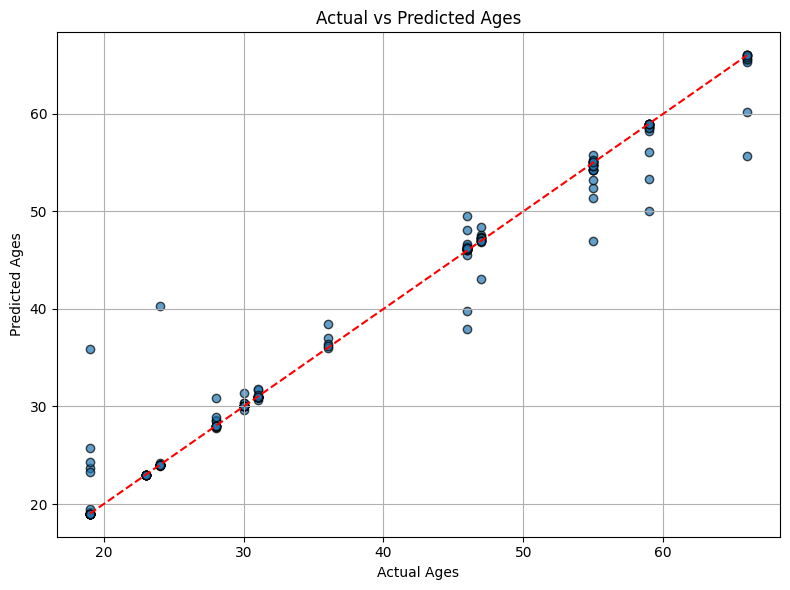

In [ ]:
#regression task

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(features_pca_11, labels, test_size=0.2, random_state=42)

rf_regressor = RandomForestRegressor(random_state=42, n_estimators=100)
rf_regressor.fit(X_train_reg, y_train_reg)

y_pred_reg = rf_regressor.predict(X_test_reg)

mse = mean_squared_error(y_test_reg, y_pred_reg)
r2 = r2_score(y_test_reg, y_pred_reg)
rms = root_mean_squared_error(y_test_reg, y_pred_reg)

print("Regression Results:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared (R2): {r2:.2f}")
print(f"Root Mean Squared Error (RMSE): {rms:.2f}")

plt.figure(figsize=(8, 6))
plt.scatter(y_test_reg, y_pred_reg, alpha=0.7, edgecolors='k')
plt.plot([min(y_test_reg), max(y_test_reg)], [min(y_test_reg), max(y_test_reg)], color='red', linestyle='--')
plt.title('Actual vs Predicted Ages')
plt.xlabel('Actual Ages')
plt.ylabel('Predicted Ages')
plt.grid(True)
plt.tight_layout()
plt.show()
nn_model.save('regression_model_path.keras')


In [ ]:

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='r2')
grid_search.fit(X_train_reg, y_train_reg)

print("Best Parameters:", grid_search.best_params_)
rf_regressor = grid_search.best_estimator_


Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


In [ ]:

# ART and MRT regression task
art_scores = [21, 14, 5, 2, 0, 7, 7, 2, 11 , 9, 36, 3, 5, 9, 11]
mrt_scores = [4, 1, 4, 0, -1, 11, 11, 9, 5 ,13, 26, 9, 1, 18, 2]
# Flatten epoch-level matrices
epoch_features = np.array([sym_matrix_to_vec(combined_connectivity_matrix[:, :, i], discard_diagonal=True)
                           for i in range(combined_connectivity_matrix.shape[2])])

art_scores_epochs = np.repeat(art_scores, slice_counts)
mrt_scores_epochs = np.repeat(mrt_scores, slice_counts)

print("Epoch Features Shape:", epoch_features.shape)
print("ART Epoch Scores Shape:", art_scores_epochs.shape)
print("MRT Epoch Scores Shape:", mrt_scores_epochs.shape)


Epoch Features Shape: (1023, 10878)
ART Epoch Scores Shape: (1023,)
MRT Epoch Scores Shape: (1023,)


In [ ]:
X_train_art, X_test_art, y_train_art, y_test_art = train_test_split(features_pca, art_scores_epochs, test_size=0.3, random_state=42)

X_train_mrt, X_test_mrt, y_train_mrt, y_test_mrt = train_test_split(features_pca, mrt_scores_epochs, test_size=0.3, random_state=42)


In [ ]:
from sklearn.linear_model import Ridge
ridge_art = Ridge(alpha=1.0, random_state=42)
ridge_art.fit(X_train_art, y_train_art)
art_predictions_ridge = ridge_art.predict(X_test_art)

art_mse_ridge = mean_squared_error(y_test_art, art_predictions_ridge)
art_r2_ridge = r2_score(y_test_art, art_predictions_ridge)
print(f"Ridge Regression (ART) - MSE: {art_mse_ridge}, R²: {art_r2_ridge}")

ridge_mrt = Ridge(alpha=1.0, random_state=42)
ridge_mrt.fit(X_train_mrt, y_train_mrt)
mrt_predictions_ridge = ridge_mrt.predict(X_test_mrt)

mrt_mse_ridge = mean_squared_error(y_test_mrt, mrt_predictions_ridge)
mrt_r2_ridge = r2_score(y_test_mrt, mrt_predictions_ridge)
print(f"Ridge Regression (MRT) - MSE: {mrt_mse_ridge}, R²: {mrt_r2_ridge}")




Ridge Regression (ART) - MSE: 6.878785858668116, R²: 0.9208918852283782
Ridge Regression (MRT) - MSE: 13.027219063277158, R²: 0.7587773841572159


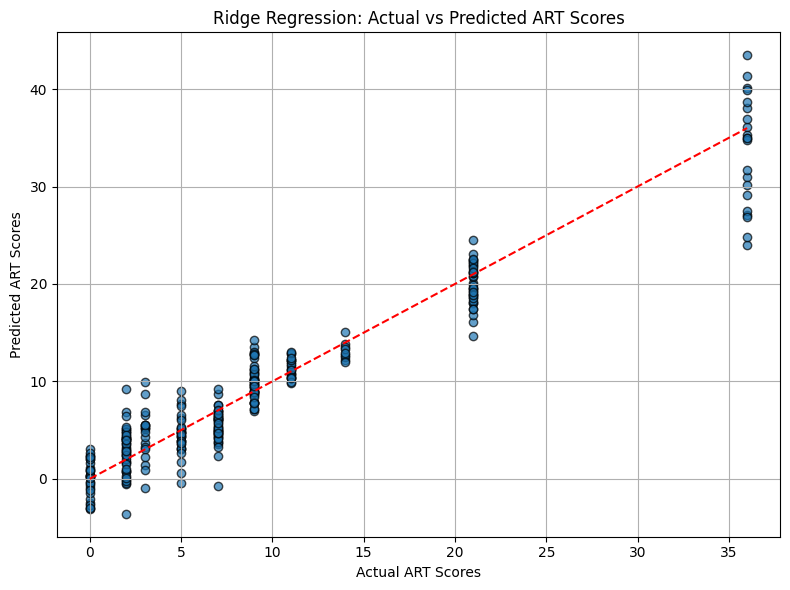

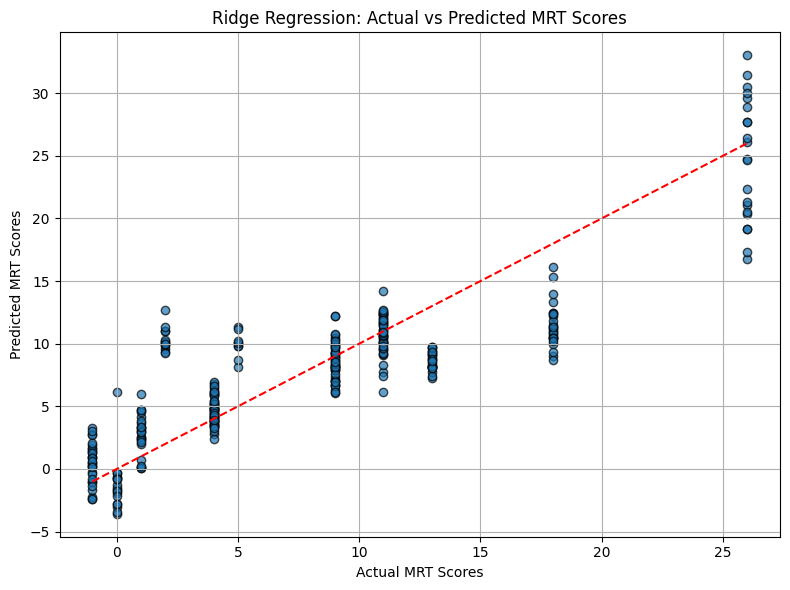

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test_art, art_predictions_ridge, alpha=0.7, edgecolors='k')
plt.plot([min(y_test_art), max(y_test_art)], [min(y_test_art), max(y_test_art)], color='red', linestyle='--')
plt.title('Ridge Regression: Actual vs Predicted ART Scores')
plt.xlabel('Actual ART Scores')
plt.ylabel('Predicted ART Scores')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(y_test_mrt, mrt_predictions_ridge, alpha=0.7, edgecolors='k')
plt.plot([min(y_test_mrt), max(y_test_mrt)], [min(y_test_mrt), max(y_test_mrt)], color='red', linestyle='--')
plt.title('Ridge Regression: Actual vs Predicted MRT Scores')
plt.xlabel('Actual MRT Scores')
plt.ylabel('Predicted MRT Scores')
plt.grid(True)
plt.tight_layout()
plt.show()


Testing with new data


In [ ]:
import scipy.io as sio

# File paths for the adjacency matrices
file_path_1 = '/content/drive/MyDrive/Colab Notebooks/adj_matrices/13CCadj_mat.mat'
file_path_2 = '/content/drive/MyDrive/Colab Notebooks/adj_matrices/148Gadj_mat.mat'

# Load the adjacency matrices from .mat files
signal_1 = sio.loadmat(file_path_1)  # Load the .mat file
signal_2 = sio.loadmat(file_path_2)

# Extract the adjacency matrices using the correct key
# Replace 'AdjacencyMat' with the actual key if it differs
adj_matrix_1 = signal_1.get('AdjacencyMat')
adj_matrix_2 = signal_2.get('AdjacencyMat')

# Check shapes of loaded matrices
print("Shape of adj_matrix_1:", adj_matrix_1.shape)
print("Shape of adj_matrix_2:", adj_matrix_2.shape)


Shape of adj_matrix_1: (148, 148, 36)
Shape of adj_matrix_2: (148, 148, 66)


In [ ]:
# Combine adjacency matrices
combined_connectivity_matrix = np.concatenate([adj_matrix_1, adj_matrix_2], axis=-1)

# Flatten the combined connectivity matrix
X_val = combined_connectivity_matrix.reshape(combined_connectivity_matrix.shape[0], -1).T

pca = PCA(n_components=11)
X_val_reduced = pca.fit_transform(X_val)

# Normalize the data
scaler = StandardScaler()
X_val_scaled = scaler.fit_transform(X_val_reduced)


In [ ]:
#ground truth values
y_true = np.array([72, 44])
print("Shape of y_true:", y_true.shape)


Shape of y_true: (2,)


In [ ]:
print("Model Input Shape:", model.input_shape)

Model Input Shape: (None, 11)


In [ ]:
nn_model = Sequential([
    Input(shape=(11,)),  # Update input shape to match 11 features
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.4),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(1, activation='sigmoid')
])


In [ ]:
from tensorflow.keras.models import load_model

# Load the pretrained regression model
model = load_model('/content/regression_model_path.keras')

# Predict using the model
predictions = model.predict(X_val_scaled)
print("Predictions:", predictions.flatten())


472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Predictions: [0.48958555 0.50005597 0.48046735 ... 0.51036215 0.52661735 0.53889227]


In [ ]:
predictions = predictions[:len(y_true)]

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Assume y_true contains ground truth age values
mae = mean_absolute_error(y_true, predictions)
rmse = mean_squared_error(y_true, predictions)
r2 = r2_score(y_true, predictions)
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2: {r2:.4f}")



MAE: 57.5052
RMSE: 3502.9922
R2: -16.8724


In [ ]:
adjacency_matrices2 = []

for file_path in file_paths2:
    mat_data = scipy.io.loadmat(file_path)
    key = next(key for key in mat_data.keys() if not key.startswith("__"))
    adjacency_matrices2.append(mat_data[key])

matrix_shapes = [matrix.shape for matrix in adjacency_matrices2]
matrix_shapes


[(148, 148, 39), (148, 148, 350)]

In [ ]:
combined_connectivity_matrix = np.concatenate(adjacency_matrices2, axis=-1)


In [ ]:
# Flatten the combined connectivity matrices
X_val = combined_connectivity_matrix.reshape(combined_connectivity_matrix.shape[0], -1).T

print("Validation Data Shape:", X_val.shape)
pca = PCA(n_components=4)  # Reduce to 4 features
X_val_reduced = pca.fit_transform(X_val)
print("Shape of Reduced Input:", X_val_reduced.shape)

Validation Data Shape: (57572, 148)
Shape of Reduced Input: (57572, 4)


In [ ]:
scaler = StandardScaler()
X_val_scaled = scaler.fit_transform(X_val)

In [ ]:
model = load_model('/content/regression_model_path.keras')

# Make predictions
predictions = model.predict(X_val_scaled)
print("Shape of Predictions:", predictions.shape)  # Should be (n_samples, 1)
print("Predicted Values:", predictions.flatten())

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1800/1800 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step
Shape of Predictions: (57572, 1)
Predicted Values: [0.9900261  0.9913801  0.99158806 ... 0.14714922 0.01873734 0.9034132 ]
